In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Setup the figures
execfile('../code/figure-setup.py')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# Upload the fitting results for the C12 model
bat_c12 = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)

# Remove 'bad' sources
radio_loud_sources = np.array(['PICTORA', '3C111.0', '3C120',
                              '2MASXJ23272195+1524375', 'PKS2331-240',
                              'HB890241+622', 'Mrk3'])
bat_c12 = bat_c12.drop(radio_loud_sources)
bat_c12.loc['UGC06728', 'lir_sf'] += 2.0
bat_c12.loc['UGC06728', 'mdust'] += 2.0

In [5]:
# Upload the WISE and Herschel data
# Upload the BAT fluxes for Herschel and WISE
herschel_data = pd.read_csv(data_dir+'bat_herschel.csv', index_col=0,
                            na_values=0)
wise_data = pd.read_csv(data_dir+'bat_wise.csv', index_col=0,
                        usecols=[0, 1, 2, 4, 5, 7, 8, 10, 11], na_values=0)

# SPIRE fluxes that are seriously contaminated by a companion should be upper limits
psw_flag = herschel_data['PSW_flag']
pmw_flag = herschel_data['PMW_flag']
plw_flag = herschel_data['PLW_flag']

herschel_data['PSW_err'][psw_flag == 'AD'] = herschel_data['PSW'][psw_flag == 'AD']
herschel_data['PSW'][psw_flag == 'AD'] = np.nan
herschel_data['PMW_err'][pmw_flag == 'AD'] = herschel_data['PMW'][pmw_flag == 'AD']
herschel_data['PMW'][pmw_flag == 'AD'] = np.nan
herschel_data['PLW_err'][plw_flag == 'AD'] = herschel_data['PLW'][plw_flag == 'AD']
herschel_data['PLW'][plw_flag == 'AD'] = np.nan

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning

In [46]:
use_sources = bat_c12[bat_c12['agn_frac_flag'] == 0].index
flux_ratios = pd.DataFrame(index=use_sources)

flux_ratios['agn_frac'] = bat_c12['agn_frac']
flux_ratios['agn_frac_err_low'] = bat_c12['agn_frac_err_low']
flux_ratios['agn_frac_err_high'] = bat_c12['agn_frac_err_high']

flux_ratios['W1/W2'] = wise_data['W1']/wise_data['W2']
flux_ratios['W2/W3'] = wise_data['W2']/wise_data['W3']
flux_ratios['W3/W4'] = wise_data['W3']/wise_data['W4']
flux_ratios['W3/H70'] = wise_data['W3']/herschel_data['PACS70']
flux_ratios['W3/H160'] = wise_data['W3']/herschel_data['PACS160']
flux_ratios['W3/H250'] = wise_data['W3']/herschel_data['PSW']
flux_ratios['W4/H70'] = wise_data['W4']/herschel_data['PACS70']
flux_ratios['W4/H160'] = wise_data['W4']/herschel_data['PACS160']
flux_ratios['W4/H250'] = wise_data['W4']/herschel_data['PSW']
flux_ratios['H70/H160'] = herschel_data['PACS70']/herschel_data['PACS160']
flux_ratios['H70/H250'] = herschel_data['PACS70']/herschel_data['PSW']
flux_ratios['H160/H250'] = herschel_data['PACS160']/herschel_data['PSW']

In [42]:
hrs_data = pd.read_table('../../hrs-data/hrs_photometry.txt', index_col=0)
hrs_sed = pd.DataFrame({'W3': hrs_data['S12'], 'W4': hrs_data['S22'],
                        'PACS100': hrs_data['S100']*1000, 'PACS160': hrs_data['S160']*1000,
                        'PSW': hrs_data['S250'], 'PMW': hrs_data['S350'],
                        'PLW': hrs_data['S500']})
hrs_err = pd.DataFrame({'W3_err': hrs_data['err12'], 'W4_err': hrs_data['err22'],
                        'PACS100_err': hrs_data['err100']*1000, 'PACS160_err': hrs_data['err160']*1000,
                        'PSW_err': hrs_data['err_tot250'], 'PMW_err': hrs_data['err_tot350'],
                        'PLW_err': hrs_data['err_tot500']})
hrs_flag = hrs_data[['Flag12', 'Flag22', 'Flag100', 'Flag160', 'Flag250', 'Flag350', 'Flag500']]

hrs_err.loc[hrs_flag['Flag12'] == 0, 'W3_err'] = 5./3.*hrs_err.loc[hrs_flag['Flag12'] == 0, 'W3_err']
hrs_err.loc[hrs_flag['Flag22'] == 0, 'W4_err'] = 5./3.*hrs_err.loc[hrs_flag['Flag22'] == 0, 'W4_err']
hrs_err.loc[hrs_flag['Flag100'] == 0, 'PACS100_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag100'] == 0, 'PACS100']
hrs_err.loc[hrs_flag['Flag160'] == 0, 'PACS160_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag160'] == 0, 'PACS160']
hrs_err.loc[hrs_flag['Flag250'] == 0, 'PSW_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag250'] == 0, 'PSW']
hrs_err.loc[hrs_flag['Flag350'] == 0, 'PMW_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag350'] == 0, 'PMW']
hrs_err.loc[hrs_flag['Flag500'] == 0, 'PLW_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag500'] == 0, 'PLW']

hrs_sed.loc[hrs_flag['Flag12'] == 0, 'W3'] = np.nan
hrs_sed.loc[hrs_flag['Flag22'] == 0, 'W4'] = np.nan
hrs_sed.loc[hrs_flag['Flag100'] == 0, 'PACS100'] = np.nan
hrs_sed.loc[hrs_flag['Flag160'] == 0, 'PACS160'] = np.nan
hrs_sed.loc[hrs_flag['Flag250'] == 0, 'PSW'] = np.nan
hrs_sed.loc[hrs_flag['Flag350'] == 0, 'PMW'] = np.nan
hrs_sed.loc[hrs_flag['Flag500'] == 0, 'PLW'] = np.nan

In [45]:
flux_ratios_hrs = pd.DataFrame(index=hrs_sed.index)
flux_ratios_hrs['W3/H160'] = hrs_sed['W3']/hrs_sed['PACS160']
flux_ratios_hrs['W3/H250'] = hrs_sed['W3']/hrs_sed['PSW']
flux_ratios_hrs['W4/H160'] = hrs_sed['W4']/hrs_sed['PACS160']
flux_ratios_hrs['W4/H250'] = hrs_sed['W4']/hrs_sed['PSW']
flux_ratios_hrs['agn_frac'] = np.zeros(len(flux_ratios_hrs))

In [65]:
kf_dir = '/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/'
kf_data = pd.read_table(kf_dir+'kingfish_data.txt', delimiter='\t', index_col=0, na_values=0)

flux_ratios_kf = pd.DataFrame(index=kf_data.index)
flux_ratios_kf['W3/H70'] = kf_data['IRAC4']/kf_data['PACS70']
flux_ratios_kf['W3/H160'] = kf_data['IRAC4']/kf_data['PACS160']
flux_ratios_kf['W3/H250'] = kf_data['IRAC4']/kf_data['PSW']
flux_ratios_kf['W4/H160'] = kf_data['MIPS24']/kf_data['PACS70']
flux_ratios_kf['W4/H160'] = kf_data['MIPS24']/kf_data['PACS160']
flux_ratios_kf['W4/H250'] = kf_data['MIPS24']/kf_data['PSW']
flux_ratios_kf['agn_frac'] = np.zeros(len(flux_ratios_kf))

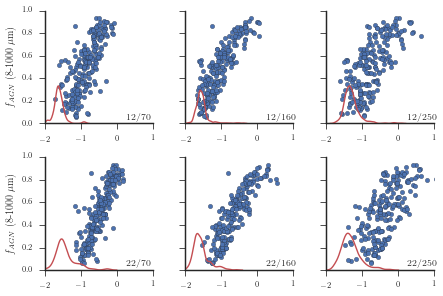

In [81]:
fig = plt.figure(figsize=(textwidth, 2./3.*textwidth))
mark_size = 20

ax1 = fig.add_subplot(231)
ax1.scatter(np.log10(flux_ratios['W3/H70']), flux_ratios['agn_frac'], c='b', s=mark_size)
ax1.text(0.75, 0.1, '12/70', ha='left', va='top', transform=ax1.transAxes)
ax1.locator_params(axis='x', nbins=5)
ax1.set_ylabel(r'$f_{AGN}$ (8-1000 $\mu$m)')
ax12 = ax1.twinx()
sn.kdeplot(np.log10(flux_ratios_kf['W3/H160']), ax=ax12, color='r', legend=False)
ax12_ylim = ax12.get_ylim()
ax12.set_ylim((0, ax12_ylim[1]*3))
ax12.yaxis.set_ticklabels([])
ax12.yaxis.set_ticks([])
ax12.set_xlim(-2, 1)
ax1.set_ylim(0, 1)

ax2 = fig.add_subplot(232)
ax2.scatter(np.log10(flux_ratios['W3/H160']), flux_ratios['agn_frac'], c='b', s=mark_size)
ax2.yaxis.set_ticklabels([])
ax2.text(0.75, 0.1, '12/160', ha='left', va='top', transform=ax2.transAxes)
ax2.locator_params(axis='x', nbins=5)
ax22 = ax2.twinx()
sn.kdeplot(np.log10(flux_ratios_hrs['W3/H160']), ax=ax22, color='r', legend=False)
ax22_ylim = ax22.get_ylim()
ax22.set_ylim((ax22_ylim[0], ax22_ylim[1]*3))
ax22.yaxis.set_ticklabels([])
ax22.yaxis.set_ticks([])
ax22.set_xlim(-2, 1)
ax2.set_ylim(0, 1)

ax3 = fig.add_subplot(233)
plt.scatter(np.log10(flux_ratios['W3/H250']), flux_ratios['agn_frac'], c='b', s=mark_size)
ax3.yaxis.set_ticklabels([])
ax3.text(0.75, 0.1, '12/250', ha='left', va='top', transform=ax3.transAxes)
ax3.locator_params(axis='x', nbins=5)
ax32 = ax3.twinx()
sn.kdeplot(np.log10(flux_ratios_hrs['W3/H250']), ax=ax32, color='r', legend=False)
ax32_ylim = ax32.get_ylim()
ax32.set_ylim((ax32_ylim[0], ax32_ylim[1]*3))
ax32.yaxis.set_ticklabels([])
ax32.yaxis.set_ticks([])
ax32.set_xlim(-2, 1)

ax4 = fig.add_subplot(234)
plt.scatter(np.log10(flux_ratios['W4/H70']), flux_ratios['agn_frac'], c='b', s=mark_size)
ax4.set_ylabel(r'$f_{AGN}$ (8-1000 $\mu$m)')
ax4.text(0.75, 0.1, '22/70', ha='left', va='top', transform=ax4.transAxes)
ax4.locator_params(axis='x', nbins=5)
ax42 = ax4.twinx()
sn.kdeplot(np.log10(flux_ratios_kf['W4/H160']), ax=ax42, color='r', legend=False)
ax42_ylim = ax42.get_ylim()
ax42.set_ylim((ax42_ylim[0], ax42_ylim[1]*3))
ax42.yaxis.set_ticklabels([])
ax42.yaxis.set_ticks([])
ax42.set_xlim(-2, 1)
ax4.set_ylim(0, 1)

ax5 = fig.add_subplot(235)
plt.scatter(np.log10(flux_ratios['W4/H160']), flux_ratios['agn_frac'], c='b', s=mark_size)
ax5.yaxis.set_ticklabels([])
ax5.text(0.75, 0.1, '22/160', ha='left', va='top', transform=ax5.transAxes)
ax5.locator_params(axis='x', nbins=5)
ax52 = ax5.twinx()
sn.kdeplot(np.log10(flux_ratios_hrs['W4/H160']), ax=ax52, color='r', legend=False)
ax52_ylim = ax52.get_ylim()
ax52.set_ylim((ax52_ylim[0], ax52_ylim[1]*3))
ax52.yaxis.set_ticklabels([])
ax52.yaxis.set_ticks([])
ax52.set_xlim(-2, 1)
ax5.set_ylim(0, 1)

ax6 = fig.add_subplot(236)
plt.scatter(np.log10(flux_ratios['W4/H250']), flux_ratios['agn_frac'], c='b', s=mark_size)
ax6.yaxis.set_ticklabels([])
ax6.text(0.75, 0.1, '22/250', ha='left', va='top', transform=ax6.transAxes)
ax6.locator_params(axis='x', nbins=5)
ax62 = ax6.twinx()
sn.kdeplot(np.log10(flux_ratios_hrs['W4/H250']), ax=ax62, color='r', legend=False)
ax62_ylim = ax62.get_ylim()
ax62.set_ylim((ax62_ylim[0], ax62_ylim[1]*3))
ax62.yaxis.set_ticklabels([])
ax62.yaxis.set_ticks([])
ax62.set_xlim(-2, 1)

fig.subplots_adjust(hspace=0.3, wspace=0.3)
sn.despine()

fig.savefig(figsave_dir+'agnfrac_vs_flux_ratio.pdf', bbox_inches='tight')

In [83]:
np.log10(flux_ratios['W3/H70']).min()

-1.7024546980102426